In [1]:
pip install dascore 

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install stepfunctions

Note: you may need to restart the kernel to use updated packages.


/var/folders/f3/q506szf54x57lwflbyc7ykvh0000gn/T/ipykernel_36858/1214029644.py:30: RuntimeWarning: divide by zero encountered in divide
  ratio = stavalues / ltavalues


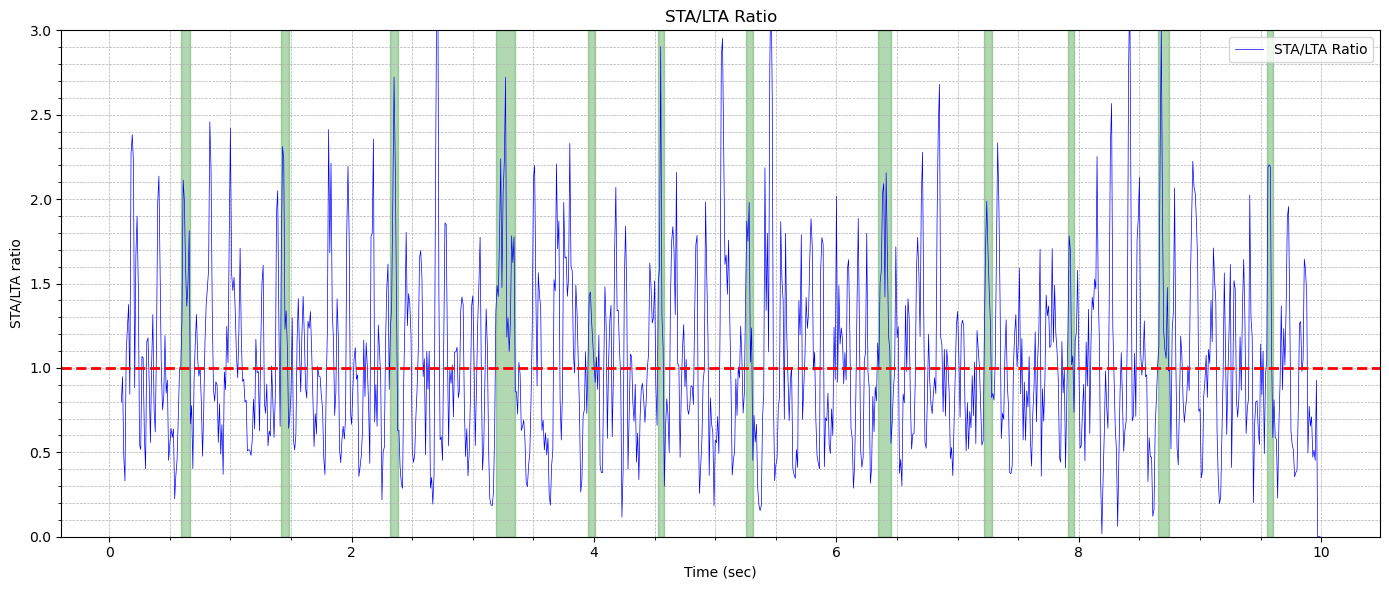

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def staltatrigger(timeseries, samplingrate, stawindowduration, ltawindowduration, stepsizeduration, detection_threshold): 
    ltawindowlength = int(ltawindowduration * samplingrate) #convert the window durations from seconds to samples 
    stawindowlength = int(stawindowduration * samplingrate) 
    stepsizesamples = int(stepsizeduration * samplingrate)
    n = np.std(timeseries)  # Calculate n dynamically based on the standard deviation of the timeseries

    # arrays to store STA, LTA, and ratio values
    stavalues = np.empty(len(timeseries) - ltawindowlength) 
    ltavalues = np.empty(len(timeseries) - ltawindowlength) 
    ratio = np.zeros(len(timeseries) - ltawindowlength)  # np.zeros = array of a specific type, all entries are zero here. 

    # Compute STA and LTA values and the ratio
    for i in range(ltawindowlength, len(timeseries) - stawindowlength, stepsizesamples):  # Range: ltawindowlength to ensure enough data for LTA
        stastart = i  # Define the start and end points of the STA/LTA windows 
        staend = i + stawindowlength 
        ltastart = i - ltawindowlength 
        ltaend = i 
        #loop through the time series to calculate STA/LTA and define window start and end points 
        stavalues[i - ltawindowlength] = np.mean(np.abs(timeseries[stastart:staend]))  # Absolute values of the signal in short-term window
        ltavalues[i - ltawindowlength] = np.mean(np.abs(timeseries[ltastart:ltaend]))  # Absolute values of the signal in long-term window

        sta = stavalues[i - ltawindowlength]
        lta = ltavalues[i - ltawindowlength]



        ratio = stavalues / ltavalues 

    # Event detection based on STA/LTA ratio, if either STA/LTA is zero, th ratio is zero 
    events = []
    min_event_duration_samples = int(0.05 * samplingrate)  # Minimum event duration (50 ms)
    min_event_separation_samples = int(0.5 * samplingrate)  # Minimum event separation (0.5 s)
    event_active = False
    event_start = None
    #loop thrhough the ratios to detect events based on the threshold and if the ratio is higher than the threshold, start an event. End the event if the ratio falls below the threshold and check duration/separation criteria before storing events 
    for i in range(len(ratio)):
        if ratio[i] > detection_threshold:
            if not event_active:
                event_start = i
                event_active = True
        else:
            if event_active:
                event_end = i
                event_active = False
                if event_end - event_start >= min_event_duration_samples:
                    if len(events) == 0 or event_start - events[-1][1] >= min_event_separation_samples:
                        events.append((event_start, event_end))

    return stavalues, ltavalues, ratio, events

# Define parameters from the paper 
samplingrate = 100.0  # Hz
stawindowduration = 0.03  #30 ms (120 samples) 
ltawindowduration = 0.1  # 100ms (400 samples) 
stepsizeduration = 0.01  # in seconds (10 ms)
detection_threshold = 1.00  # STA/LTA detection threshold



#synthetic seismic data through time series 
np.random.seed(0)
timeseries = np.random.randn(1000)  

# Apply STA/LTA method
sta, lta, staltaratio, events = staltatrigger(timeseries, samplingrate, stawindowduration, ltawindowduration, stepsizeduration, detection_threshold)

# Define time array for plotting
ltawindowlength = int(ltawindowduration * samplingrate)  # Redefine here for usage
stepsizesamples = int(stepsizeduration * samplingrate)   # Redefine here for usage
time = np.arange(len(timeseries)) / samplingrate
time_stalta = time[ltawindowlength:ltawindowlength + len(sta) * stepsizesamples:stepsizesamples]

# Plotting the results
plt.figure(figsize=(14, 6))

# Plot STA/LTA ratio
plt.plot(time_stalta, staltaratio, label='STA/LTA Ratio', color='blue', linewidth=0.5)
plt.axhline(y=detection_threshold, color='red', linestyle='--', linewidth=2)  # Add detection threshold line
plt.title('STA/LTA Ratio')
plt.xlabel('Time (sec)')
plt.ylabel('STA/LTA ratio')
plt.ylim(0, 3)  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.legend()

# Mark detected events
for event in events:
    plt.axvspan(time_stalta[event[0]], time_stalta[event[1]], color='green', alpha=0.3)

plt.tight_layout()
plt.show()


.....
----------------------------------------------------------------------
Ran 5 tests in 0.033s

OK


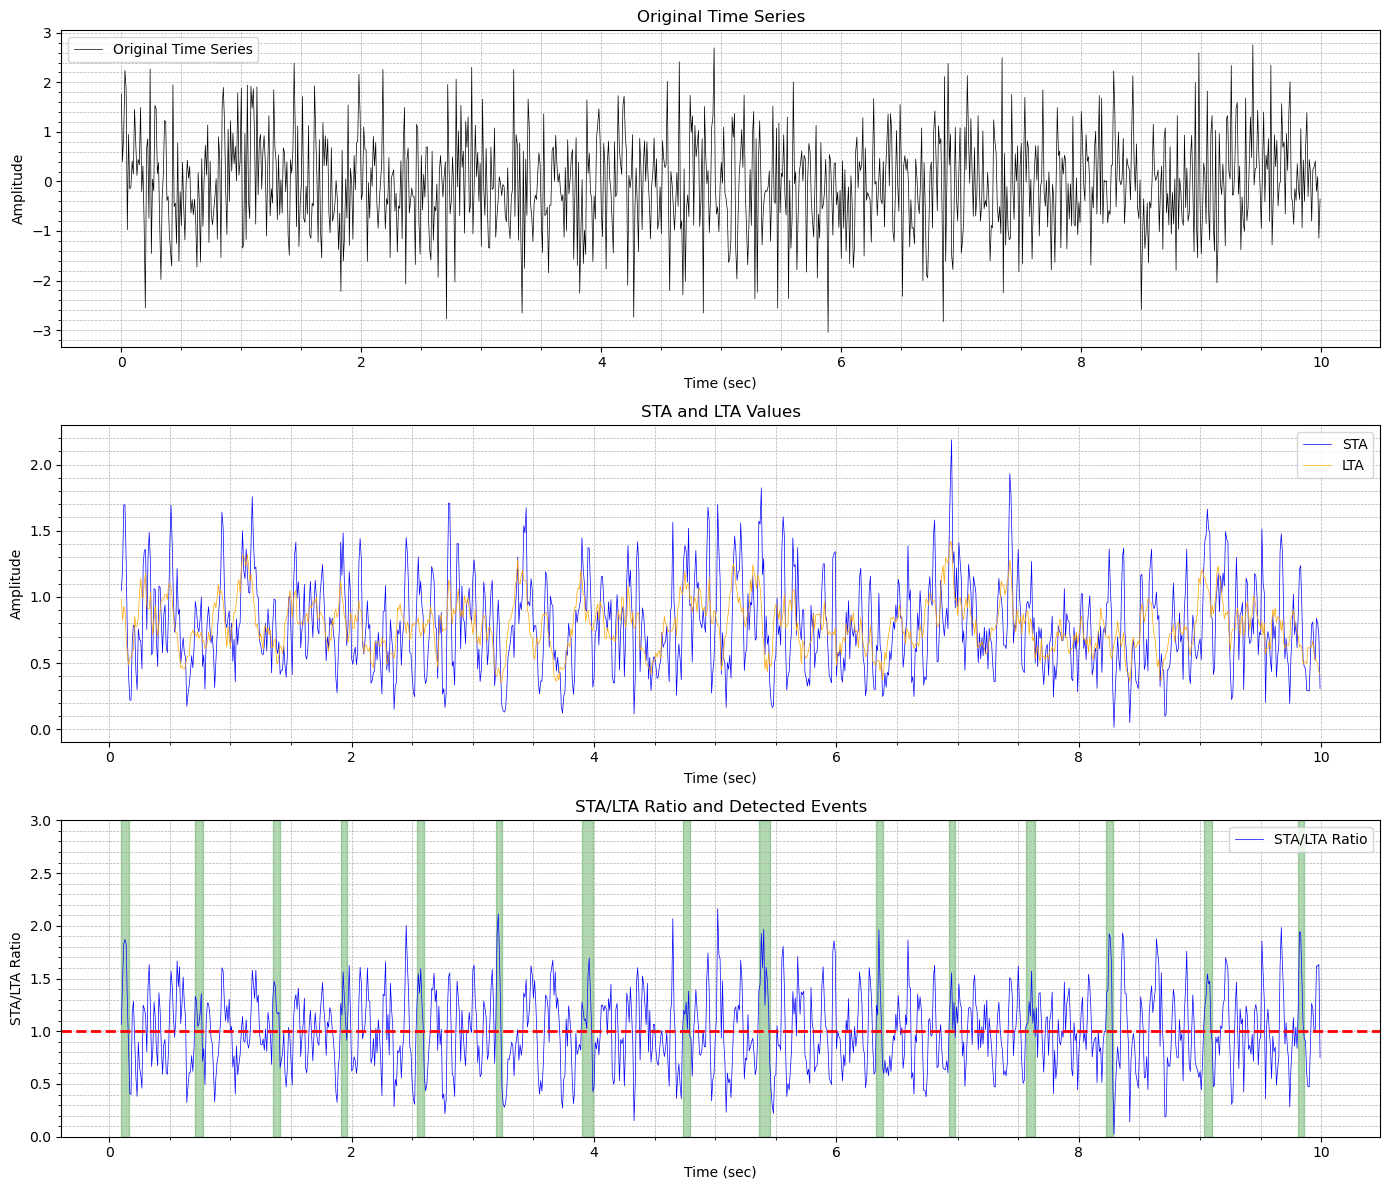

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import unittest

# Function to compute STA values
def compute_sta(timeseries, samplingrate, stawindowduration):
    stawindowlength = int(stawindowduration * samplingrate)  # Number of samples in the STA window
    stavalues = np.array([np.mean(np.abs(timeseries[i:i+stawindowlength])) 
                          for i in range(len(timeseries) - stawindowlength)])  # Calculate STA values as per Eq. (1) in the paper
    return stavalues

# Function to compute LTA values
def compute_lta(timeseries, samplingrate, ltawindowduration):
    ltawindowlength = int(ltawindowduration * samplingrate)  # Number of samples in the LTA window
    ltavalues = np.array([np.mean(np.abs(timeseries[i:i+ltawindowlength])) 
                          for i in range(len(timeseries) - ltawindowlength)])  # Calculate LTA values as per Eq. (2) in the paper
    return ltavalues

# Function to compute the ratio of STA/LTA
def compute_ratio(stavalues, ltavalues):
    min_length = min(len(stavalues), len(ltavalues))  # Ensure arrays are equal length for division
    ratio = stavalues[:min_length] / ltavalues[:min_length]  # Compute the STA/LTA ratio as per the methodology in the paper
    return ratio

# Function to detect events based on the STA/LTA ratio
def detect_events(ratio, detection_threshold, samplingrate):
    min_event_duration_samples = int(0.05 * samplingrate)  # Minimum event duration (50 ms as per Table 1 in the paper)
    min_event_separation_samples = int(0.5 * samplingrate)  # Minimum event separation (0.5 s as per Table 1 in the paper)
    events = []  # List to store detected events
    event_active = False  # Flag to indicate if an event is currently active
    event_start = None  # Start index of the current event

    # Iterate through the ratio array to detect events
    for i in range(len(ratio)):
        if ratio[i] > detection_threshold:  # Event detection based on threshold as per the methodology in the paper
            if not event_active:
                event_start = i
                event_active = True
        else:
            if event_active:
                event_end = i
                event_active = False
                if event_end - event_start >= min_event_duration_samples:
                    if len(events) == 0 or event_start - events[-1][1] >= min_event_separation_samples:
                        events.append((event_start, event_end))

    return events

# Main function to trigger STA/LTA event detection
def staltatrigger(timeseries, samplingrate, stawindowduration, ltawindowduration, stepsizeduration, detection_threshold):
    stavalues = compute_sta(timeseries, samplingrate, stawindowduration)
    ltavalues = compute_lta(timeseries, samplingrate, ltawindowduration)
    ratio = compute_ratio(stavalues, ltavalues)
    events = detect_events(ratio, detection_threshold, samplingrate)
    return stavalues, ltavalues, ratio, events

# Unit tests for the STA/LTA method
class TestSTALTAMethod(unittest.TestCase):
    
    def setUp(self):
        self.timeseries = np.random.rand(1000)
        self.samplingrate = 100.0
        self.stawindowduration = 0.03
        self.ltawindowduration = 0.1
        self.stepsizeduration = 0.01
        self.detectionthreshold = 1.0

    def test_compute_sta(self):
        sta = compute_sta(self.timeseries, self.samplingrate, self.stawindowduration)
        self.assertEqual(len(sta), len(self.timeseries) - int(self.stawindowduration * self.samplingrate))
        self.assertTrue(np.all(sta >= 0))

    def test_compute_lta(self):
        lta = compute_lta(self.timeseries, self.samplingrate, self.ltawindowduration)
        self.assertEqual(len(lta), len(self.timeseries) - int(self.ltawindowduration * self.samplingrate))
        self.assertTrue(np.all(lta >= 0))

    def test_compute_ratio(self):
        sta = compute_sta(self.timeseries, self.samplingrate, self.stawindowduration)
        lta = compute_lta(self.timeseries, self.samplingrate, self.ltawindowduration)
        ratio = compute_ratio(sta, lta)
        self.assertEqual(len(ratio), min(len(sta), len(lta)))
        self.assertTrue(np.all(ratio >= 0))

    def test_detect_events(self):
        sta = compute_sta(self.timeseries, self.samplingrate, self.stawindowduration)
        lta = compute_lta(self.timeseries, self.samplingrate, self.ltawindowduration)
        ratio = compute_ratio(sta, lta)
        events = detect_events(ratio, self.detectionthreshold, self.samplingrate)
        self.assertIsInstance(events, list)

    def test_staltatrigger(self):
        sta, lta, ratio, events = staltatrigger(self.timeseries, self.samplingrate, self.stawindowduration, self.ltawindowduration, self.stepsizeduration, self.detectionthreshold)
        self.assertEqual(len(sta), len(self.timeseries) - int(self.stawindowduration * self.samplingrate))
        self.assertIsInstance(events, list)

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

    # Create visuals for the unit test
    samplingrate = 100.0
    stawindowduration = 0.03
    ltawindowduration = 0.1
    stepsizeduration = 0.01
    detection_threshold = 1.0

    np.random.seed(0)
    timeseries = np.random.randn(1000)

    sta, lta, ratio, events = staltatrigger(timeseries, samplingrate, stawindowduration, ltawindowduration, stepsizeduration, detection_threshold)

    ltawindowlength = int(ltawindowduration * samplingrate)
    stepsizesamples = int(stepsizeduration * samplingrate)
    min_length = min(len(sta), len(lta))
    time = np.arange(len(timeseries)) / samplingrate
    time_stalta = time[ltawindowlength:ltawindowlength + min_length * stepsizesamples:stepsizesamples]

    plt.figure(figsize=(14, 12))

    # Plot the original timeseries
    plt.subplot(3, 1, 1)
    plt.plot(time, timeseries, label='Original Time Series', color='black', linewidth=0.5)
    plt.title('Original Time Series')
    plt.xlabel('Time (sec)')
    plt.ylabel('Amplitude')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    plt.legend()

    # Plot STA and LTA values
    plt.subplot(3, 1, 2)
    plt.plot(time_stalta, sta[:min_length], label='STA', color='blue', linewidth=0.5)
    plt.plot(time_stalta, lta[:min_length], label='LTA', color='orange', linewidth=0.5)
    plt.title('STA and LTA Values')
    plt.xlabel('Time (sec)')
    plt.ylabel('Amplitude')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    plt.legend()

    # Plot STA/LTA ratio and detected events
    plt.subplot(3, 1, 3)
    plt.plot(time_stalta, ratio, label='STA/LTA Ratio', color='blue', linewidth=0.5)
    plt.axhline(y=detection_threshold, color='red', linestyle='--', linewidth=2)  # Add detection threshold line
    plt.title('STA/LTA Ratio and Detected Events')
    plt.xlabel('Time (sec)')
    plt.ylabel('STA/LTA Ratio')
    plt.ylim(0, 3)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    plt.legend()

    # Mark detected events
    for event in events:
        plt.axvspan(time_stalta[event[0]], time_stalta[event[1]], color='green', alpha=0.3)

    plt.tight_layout()
    plt.show()


/var/folders/f3/q506szf54x57lwflbyc7ykvh0000gn/T/ipykernel_36858/2670227115.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = (ltavalues[:min_length] * lta_term) / (stavalues[:min_length] * sta_term)


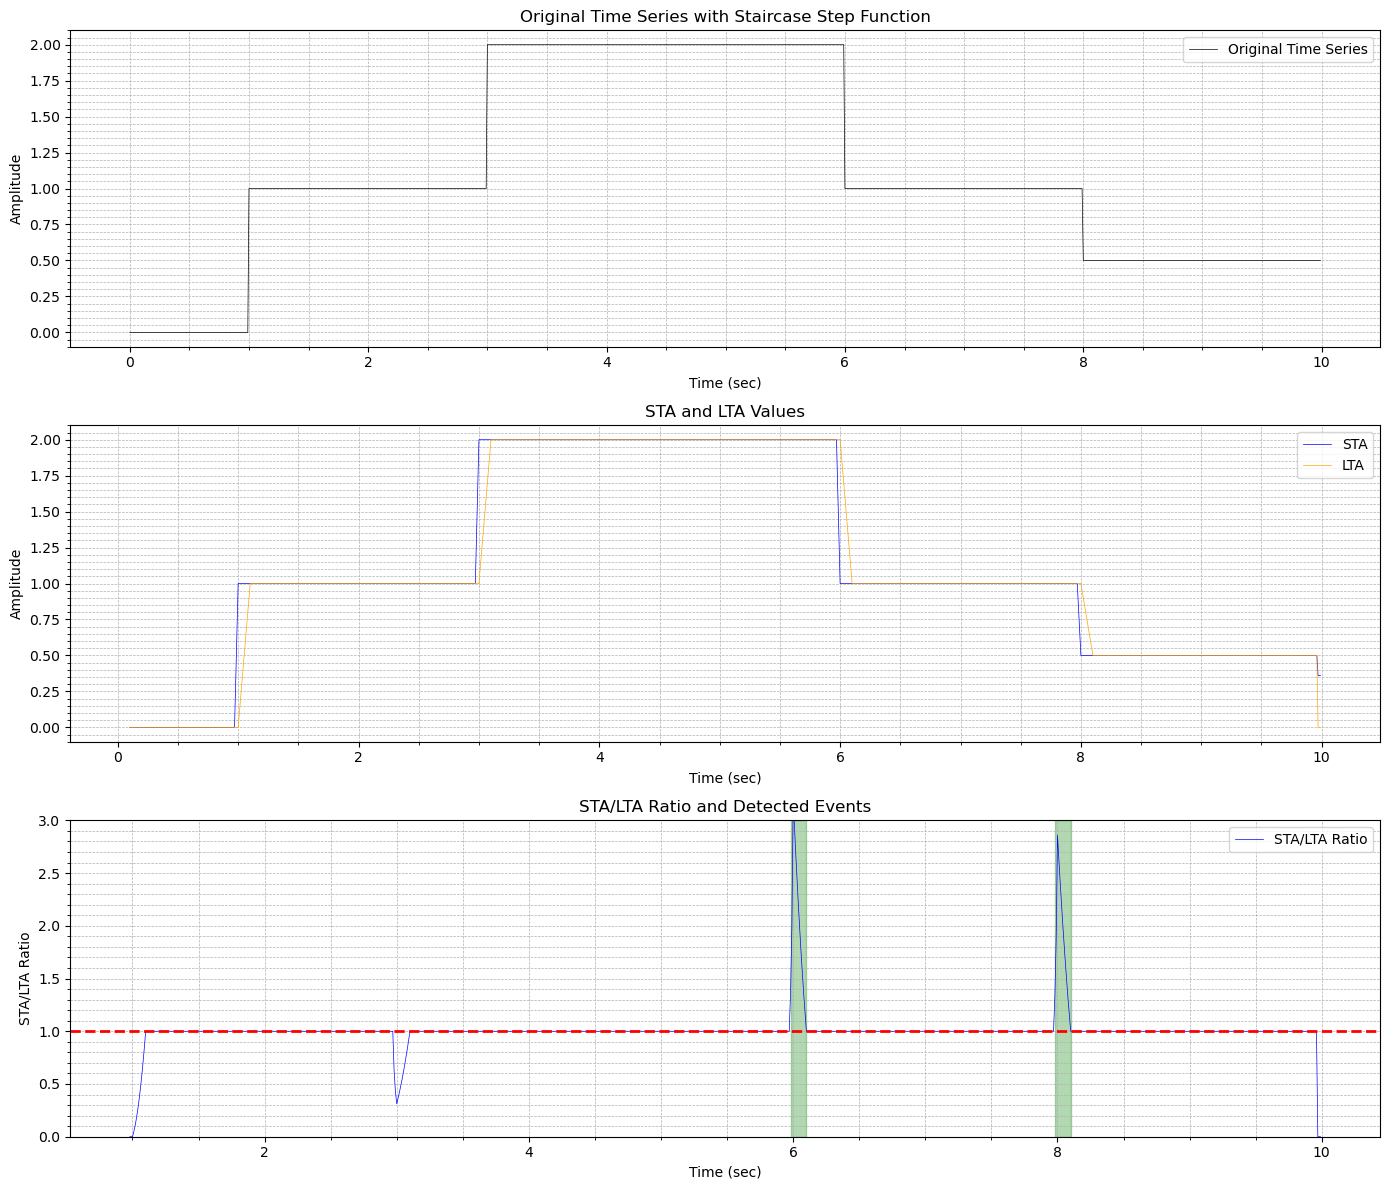

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def compute_sta(timeseries, samplingrate, stawindowduration):
    stawindowlength = int(stawindowduration * samplingrate)  # Number of samples in the STA window
    stavalues = np.array([np.mean(np.abs(timeseries[i:i+stawindowlength])) 
                          for i in range(len(timeseries) - stawindowlength)])  
    return stavalues

def compute_lta(timeseries, samplingrate, ltawindowduration):
    ltawindowlength = int(ltawindowduration * samplingrate)  # Number of samples in the LTA window
    ltavalues = np.array([np.mean(np.abs(timeseries[i:i+ltawindowlength])) 
                          for i in range(len(timeseries) - ltawindowlength)])  
    return ltavalues

def compute_sta_lta_ratio(stavalues, ltavalues, n):
    min_length = min(len(stavalues), len(ltavalues))
    sta_term = n * 2 + (stavalues[:min_length] - n) * 1
    lta_term = n * 2 + (ltavalues[:min_length] - n) * 1
    ratio = (ltavalues[:min_length] * lta_term) / (stavalues[:min_length] * sta_term)
    return ratio

def staltatrigger(timeseries, samplingrate, stawindowduration, ltawindowduration, stepsizeduration, detection_threshold):
    ltawindowlength = int(ltawindowduration * samplingrate)  # Convert the window durations from seconds to samples
    stawindowlength = int(stawindowduration * samplingrate)
    stepsizesamples = int(stepsizeduration * samplingrate)
    n = np.std(timeseries)  # Calculate n dynamically based on the standard deviation of the timeseries

    # Arrays to store STA, LTA, and ratio values
    stavalues = np.empty(len(timeseries) - ltawindowlength)
    ltavalues = np.empty(len(timeseries) - ltawindowlength)

    # Compute STA and LTA values
    for i in range(ltawindowlength, len(timeseries) - stawindowlength, stepsizesamples):
        stastart = i
        staend = i + stawindowlength
        ltastart = i - ltawindowlength
        ltaend = i
        stavalues[i - ltawindowlength] = np.mean(np.abs(timeseries[stastart:staend]))
        ltavalues[i - ltawindowlength] = np.mean(np.abs(timeseries[ltastart:ltaend]))

    # Compute STA/LTA ratio using the provided formula
    ratio = compute_sta_lta_ratio(stavalues, ltavalues, n)

    # Event detection based on STA/LTA ratio
    events = []
    min_event_duration_samples = int(0.05 * samplingrate)  # Minimum event duration (50 ms)
    min_event_separation_samples = int(0.5 * samplingrate)  # Minimum event separation (0.5 s)
    event_active = False
    event_start = None
    for i in range(len(ratio)):
        if ratio[i] > detection_threshold:
            if not event_active:
                event_start = i
                event_active = True
        else:
            if event_active:
                event_end = i
                event_active = False
                if event_end - event_start >= min_event_duration_samples:
                    if len(events) == 0 or event_start - events[-1][1] >= min_event_separation_samples:
                        events.append((event_start, event_end))

    return stavalues, ltavalues, ratio, events

# Define parameters from the paper
samplingrate = 100.0  # Hz
stawindowduration = 0.03  # 30 ms
ltawindowduration = 0.1  # 100 ms
stepsizeduration = 0.01  # in seconds
detection_threshold = 1.0  # STA/LTA detection threshold

# Create a timeseries with a staircase step function
np.random.seed(0)
timeseries = np.zeros(1000)
timeseries[100:300] = 1
timeseries[300:600] = 2
timeseries[600:800] = 1
timeseries[800:] = 0.5

# Apply STA/LTA method
sta, lta, staltaratio, events = staltatrigger(timeseries, samplingrate, stawindowduration, ltawindowduration, stepsizeduration, detection_threshold)

# Define time array for plotting
ltawindowlength = int(ltawindowduration * samplingrate)
stepsizesamples = int(stepsizeduration * samplingrate)
time = np.arange(len(timeseries)) / samplingrate
time_stalta = time[ltawindowlength:ltawindowlength + len(sta) * stepsizesamples:stepsizesamples]

# Plotting the results
plt.figure(figsize=(14, 12))

# Plot the original timeseries
plt.subplot(3, 1, 1)
plt.plot(time, timeseries, label='Original Time Series', color='black', linewidth=0.5)
plt.title('Original Time Series with Staircase Step Function')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.legend()

# Plot STA and LTA values
plt.subplot(3, 1, 2)
plt.plot(time_stalta, sta[:min_length], label='STA', color='blue', linewidth=0.5)
plt.plot(time_stalta, lta[:min_length], label='LTA', color='orange', linewidth=0.5)
plt.title('STA and LTA Values')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.legend()

# Plot STA/LTA ratio and detected events
plt.subplot(3, 1, 3)
plt.plot(time_stalta, staltaratio, label='STA/LTA Ratio', color='blue', linewidth=0.5)
plt.axhline(y=detection_threshold, color='red', linestyle='--', linewidth=2)  # Add detection threshold line
plt.title('STA/LTA Ratio and Detected Events')
plt.xlabel('Time (sec)')
plt.ylabel('STA/LTA Ratio')
plt.ylim(0, 3)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.legend()

# Mark detected events
for event in events:
    plt.axvspan(time_stalta[event[0]], time_stalta[event[1]], color='green', alpha=0.3)

plt.tight_layout()
plt.show()
